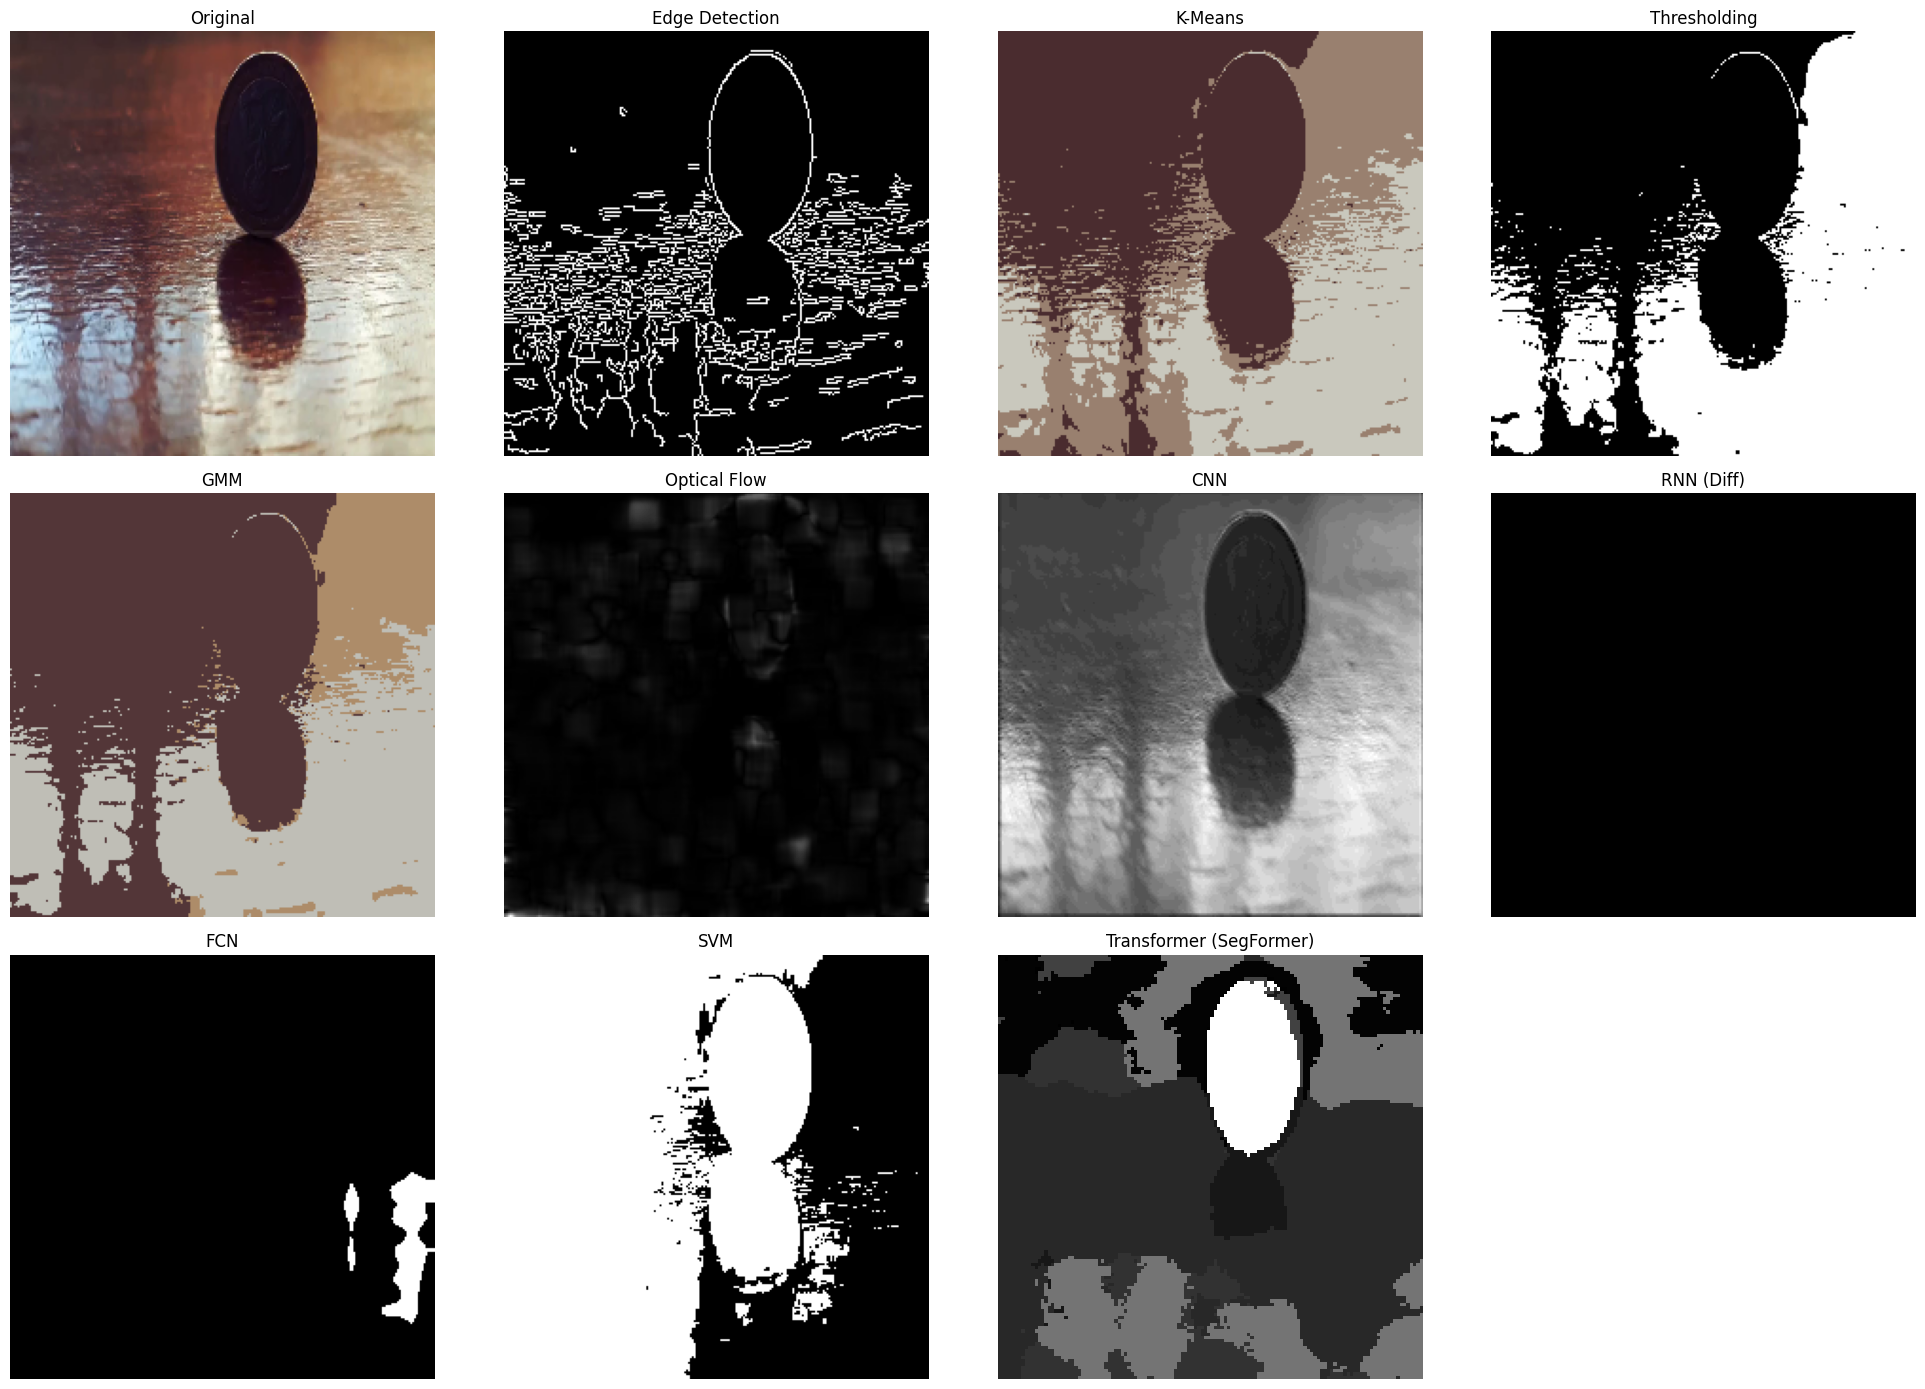

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.models.segmentation as models
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
import warnings
warnings.filterwarnings("ignore")

# --- Read video and 2 frames 
cap = cv2.VideoCapture("3D Objects/12564-240358890_small.mp4")
ret1, frame1 = cap.read()
ret2, frame2 = cap.read()
cap.release()

if not (ret1 and ret2):
    print("Failed to read video.")
    exit()

frame1 = cv2.resize(frame1, (224, 224))
frame2 = cv2.resize(frame2, (224, 224))
original_frame = frame1.copy()

# --- 1. Edge Detection ---
edges = cv2.Canny(frame1, 100, 200)

# --- 2. K-Means ---
pixels = frame1.reshape((-1, 3))
kmeans = KMeans(n_clusters=3, n_init=10).fit(pixels)
kmeans_segmented = kmeans.cluster_centers_[kmeans.labels_].reshape(frame1.shape).astype(np.uint8)

# --- 3. Thresholding ---
gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
_, thresholded = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)

# --- 4. GMM ---
gmm = GaussianMixture(n_components=3, covariance_type='tied').fit(pixels)
gmm_labels = gmm.predict(pixels)
gmm_segmented = gmm.means_[gmm_labels].reshape(frame1.shape).astype(np.uint8)

# --- 5. Optical Flow ---
gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
magnitude, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
optical_flow_img = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# --- 6. CNN Segmentation (Simple) ---
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 1, 3, padding=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.conv(x)

cnn_model = SimpleCNN()
input_tensor = torch.from_numpy(frame1.transpose(2, 0, 1)).unsqueeze(0).float() / 255.0
cnn_output = cnn_model(input_tensor)[0, 0].detach().numpy()
cnn_seg = (cnn_output * 255).astype(np.uint8)

# --- 7. RNN Simulated via Frame Difference ---
frame_diff = cv2.absdiff(gray1, gray2)
_, rnn_simulated = cv2.threshold(frame_diff, 25, 255, cv2.THRESH_BINARY)

# --- 8. FCN Segmentation ---
fcn_model = models.fcn_resnet50(pretrained=True).eval()
transform = T.Compose([
    T.ToPILImage(),
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])
tensor = transform(frame1).unsqueeze(0)
with torch.no_grad():
    fcn_output = fcn_model(tensor)['out'][0].argmax(0).byte().cpu().numpy()

# --- 9. SVM Segmentation ---
sample_size = 5000
indices = np.random.choice(len(pixels), sample_size, replace=False)
sample_pixels = pixels[indices]
labels = np.random.randint(0, 2, sample_size)  # dummy labels
svm = SVC(kernel='linear')
svm.fit(sample_pixels, labels)
pred_labels = svm.predict(pixels)
svm_segmented = (pred_labels * 255).reshape((224, 224)).astype(np.uint8)

# --- 10. Transformer Segmentation (SegFormer) ---
extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model_tf = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
inputs = extractor(images=frame1, return_tensors="pt")
with torch.no_grad():
    outputs = model_tf(**inputs)
    logits = outputs.logits
seg_map = logits.argmax(dim=1)[0].cpu().numpy()

# --- Display ---
titles = [
    'Original', 'Edge Detection', 'K-Means', 'Thresholding',
    'GMM', 'Optical Flow', 'CNN', 'RNN (Diff)',
    'FCN', 'SVM', 'Transformer (SegFormer)'
]
images = [
    original_frame, edges, kmeans_segmented, thresholded,
    gmm_segmented, optical_flow_img, cnn_seg, rnn_simulated,
    fcn_output, svm_segmented, seg_map
]

plt.figure(figsize=(20, 14))
for i in range(11):
    plt.subplot(3, 4, i+1)
    if titles[i] in ['Edge Detection', 'Thresholding', 'Optical Flow', 'CNN', 'RNN (Diff)', 'FCN', 'SVM', 'Transformer (SegFormer)']:
        plt.imshow(images[i], cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()
